In [1]:
#!pip list
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy     as np
import xarray    as xr
import time      as clock
import datetime 

/albedo/home/pscholz/tripyview


## INFO:
To compute the MOC especially on large unstructures grids #vertices>1M you need to run this notebook in parallel on several workers. Therefor allocate a full compute node of a HPC with as much memory as you can get!

In [2]:
from dask.distributed import Client
from dask.diagnostics import ProgressBar
import dask

n_workers= 24  #36 #48 #64 #96
tot_mem  = 256 #100 # GB
print(' --> memory_limit: {:3.3f} GB'.format(tot_mem/(n_workers+1)))
#dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
dask.config.config.get('distributed').get('dashboard')
client = Client(n_workers=n_workers, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(tot_mem/n_workers))
client

 --> memory_limit: 10.240 GB


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 24,Total memory: 238.43 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45217,Workers: 24
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 238.43 GiB
Comm: tcp://127.0.0.1:41093,Total threads: 1
Dashboard: http://127.0.0.1:44041/status,Memory: 9.93 GiB
Nanny: tcp://127.0.0.1:37159,


In [3]:
#_____________________________________________________________________________________
# set mesh path
mesh_path  = '/albedo/work/user/pscholz/data_cmpi6/bold/'
# set path to save figures and netcdf files
save_path  = '~/figures/test_MOC_f14cmip6/' # None

# set datapath
input_paths= list()
input_paths.append('/albedo/work/user/pscholz/data_cmpi6/')

#_____________________________________________________________________________________
# set run infos
which_model= 'AWI-CM-1-1-HR'
which_run  = 'control-1950'
vname      = 'amoc'  # gmoc, amoc, ipmoc, imoc, pmoc
year       = [1951, 2050]
dyr        = 10

#_____________________________________________________________________________________
cstr       = 'blue2red'
cnum, cref, crange, cmin, cmax, cfac, climit = 20, 0, None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
which_dpi  = 300
figfac     = [8, 3.5] #[7, 3.5]
do_netcdf  = True
do_info    = True

## > Load mesh:

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True, do_f14cmip6=True)

#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)

#______________________________________________________________________________________________________        
if save_path is not None:
    if not os.path.isdir(save_path): os.makedirs(save_path)

#______________________________________________________________________________________________________                
chunks ={'time'   :100, 
         'nod2'   :np.ceil(mesh.n2dn/n_workers), 
         'elem'   :np.ceil(mesh.n2de/n_workers), 
         'ncells' :np.ceil(mesh.n2dn/n_workers), 
         'ntriags':np.ceil(mesh.n2de/n_workers)}        

 > warning: pickle5 module could not be found, no do_pickle 
 is possible! Therefor switch to joblib saving/loading
 > found *.jlib file: /albedo/work/user/pscholz/data_cmpi6/bold
 > load  *.jlib file: tripyview_fesom2_bold_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/data_cmpi6/bold
 > id              = bold
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 1306775
 > #elem           = 2583730
 > #lvls           = 46
___________________________________________


##  > Compute: MOC vs. time
- compute annual mean MOC from monthly mean FESOM1.4 AWI-CM-1-1-HR CMIP6 vertical velocities (var:wo)

In [5]:
#______________________________________________________________________________________________________
ts     = clock.time()
zmoc_t = xr.Dataset()
for ii, datapath in enumerate(input_paths): 
    print(datapath)

    #__________________________________________________________________________________________________
    # loop over year to open 10-year bundled files 
    t1s = clock.time()
    for yr in range(year[0], year[1]+1, dyr):
        
        #______________________________________________________________________________________________
        # load cmip6 filename
        fname       = f'wo_Omon_{which_model}_{which_run}_r1i1p1f2_gn_{yr}01-{yr+dyr-1}12.nc'
        filepath    = os.path.join(datapath, fname)
        print(' --> open file:', fname)
        
        # load data via xarray
        data = xr.open_mfdataset(filepath, parallel=True, chunks=chunks, autoclose=False)
            
        #______________________________________________________________________________________________
        # convert format from fesom14cmip6 --> fesom2
        if do_info: print('     --> convert f14cmip6 > fesom2')
        data = data.drop(['lon_bnds','lat_bnds', 'time_bnds'])
        data = data.rename_dims({'ncells':'nod2', 'depth':'nz'})
        data = data.rename({'wo':'w', 'depth':'nz'})
        data = data.transpose('time', 'nod2', 'nz')
       
        #______________________________________________________________________________________________
        # compute time mean 
        if do_info: print('     --> compute annual time mean')
        data = data.groupby('time.year').mean('time')
        
        # recreate time axes based on year
        data = data.rename_dims({'year':'time'})
        if yr in data.year.values:
            data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop('year')
        else:
            raise ValueError('--> the years you want load can not be found in the time axis of your file. Something is not OK with the data! Check on them!!!')
            
        if do_info: print('     --> xr.compute() ... load everything into memory. This can take a bit!')
        data = data.compute()
        data['w'].attrs['descript'] = f'{which_run}'
        
        #______________________________________________________________________________________________
        # compute zmoc    
        if do_info: print('     --> compute: ', vname)
        zmoc = tpv.calc_zmoc(mesh, data, dlat=1.0, which_moc=vname, do_info=do_info, do_checkbasin=False, do_onelem=False, diagpath=False, do_compute=True)
        del(data)
        
        #______________________________________________________________________________________________
        # accumulate to zmoc over time
        zmoc_t = xr.merge([zmoc_t, zmoc], combine_attrs='drop_conflicts') #no_conflicts
        del(zmoc)
        
        #______________________________________________________________________________________________
        t1e = clock.time()
        print('     --> elapsed time/file:', t1e-t1s, ' sec')
        t1s = t1e
        print('\n')
    
    #__________________________________________________________________________________________________
    # save to netcdf
    if do_netcdf and save_path is not None:
        auxtime   = zmoc_t['time.year'].values
        sfname    = f'{vname}_vs_t_{which_model}_{which_run}_y{auxtime[0]}-{auxtime[-1]}.nc'
        # sfilepath = os.path.join(datapath, sfname)
        sfilepath = os.path.join(save_path, sfname)
        print(' --> save zmoc_t to file:', sfname)
        zmoc_t.to_netcdf(path=sfilepath, mode='w')
    
print(' --> tot. elapsed time:', clock.time()-ts, ' sec')

/albedo/work/user/pscholz/data_cmpi6/
 --> open file: wo_Omon_AWI-CM-1-1-HR_control-1950_r1i1p1f2_gn_195101-196012.nc
     --> convert f14cmip6 > fesom2
     --> compute annual time mean
     --> xr.compute() ... load everything into memory. This can take a bit!


/tmp/ipykernel_37283/3134556518.py:26: UserWarning: rename 'depth' to 'nz' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data = data.rename({'wo':'w', 'depth':'nz'})
/tmp/ipykernel_37283/3134556518.py:37: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop('year')


     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____
 --> do binning of latitudes
 --> do sumation/integration over bins
 --> do cumsum over latitudes
 --> total time:5.446 s
     --> elapsed time/file: 66.84980583190918  sec


 --> open file: wo_Omon_AWI-CM-1-1-HR_control-1950_r1i1p1f2_gn_196101-197012.nc
     --> convert f14cmip6 > fesom2
     --> compute annual time mean
     --> xr.compute() ... load everything into memory. This can take a bit!


/tmp/ipykernel_37283/3134556518.py:26: UserWarning: rename 'depth' to 'nz' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data = data.rename({'wo':'w', 'depth':'nz'})
/tmp/ipykernel_37283/3134556518.py:37: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop('year')


     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____
 --> do binning of latitudes
 --> do sumation/integration over bins
 --> do cumsum over latitudes
 --> total time:5.176 s
     --> elapsed time/file: 31.547905921936035  sec


 --> open file: wo_Omon_AWI-CM-1-1-HR_control-1950_r1i1p1f2_gn_197101-198012.nc
     --> convert f14cmip6 > fesom2
     --> compute annual time mean


/tmp/ipykernel_37283/3134556518.py:26: UserWarning: rename 'depth' to 'nz' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data = data.rename({'wo':'w', 'depth':'nz'})
/tmp/ipykernel_37283/3134556518.py:37: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop('year')


     --> xr.compute() ... load everything into memory. This can take a bit!
     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____
 --> do binning of latitudes
 --> do sumation/integration over bins
 --> do cumsum over latitudes
 --> total time:5.002 s
     --> elapsed time/file: 31.364887714385986  sec


 --> open file: wo_Omon_AWI-CM-1-1-HR_control-1950_r1i1p1f2_gn_198101-199012.nc
     --> convert f14cmip6 > fesom2
     --> compute annual time mean


/tmp/ipykernel_37283/3134556518.py:26: UserWarning: rename 'depth' to 'nz' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data = data.rename({'wo':'w', 'depth':'nz'})
/tmp/ipykernel_37283/3134556518.py:37: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop('year')


     --> xr.compute() ... load everything into memory. This can take a bit!
     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____
 --> do binning of latitudes
 --> do sumation/integration over bins
 --> do cumsum over latitudes
 --> total time:5.182 s
     --> elapsed time/file: 35.924196004867554  sec


 --> open file: wo_Omon_AWI-CM-1-1-HR_control-1950_r1i1p1f2_gn_199101-200012.nc
     --> convert f14cmip6 > fesom2
     --> compute annual time mean


/tmp/ipykernel_37283/3134556518.py:26: UserWarning: rename 'depth' to 'nz' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data = data.rename({'wo':'w', 'depth':'nz'})
/tmp/ipykernel_37283/3134556518.py:37: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop('year')


     --> xr.compute() ... load everything into memory. This can take a bit!
     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____
 --> do binning of latitudes
 --> do sumation/integration over bins
 --> do cumsum over latitudes
 --> total time:4.972 s
     --> elapsed time/file: 32.29953336715698  sec


 --> open file: wo_Omon_AWI-CM-1-1-HR_control-1950_r1i1p1f2_gn_200101-201012.nc
     --> convert f14cmip6 > fesom2
     --> compute annual time mean


/tmp/ipykernel_37283/3134556518.py:26: UserWarning: rename 'depth' to 'nz' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data = data.rename({'wo':'w', 'depth':'nz'})
/tmp/ipykernel_37283/3134556518.py:37: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop('year')


     --> xr.compute() ... load everything into memory. This can take a bit!
     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____
 --> do binning of latitudes
 --> do sumation/integration over bins
 --> do cumsum over latitudes
 --> total time:4.975 s
     --> elapsed time/file: 31.31523871421814  sec


 --> open file: wo_Omon_AWI-CM-1-1-HR_control-1950_r1i1p1f2_gn_201101-202012.nc
     --> convert f14cmip6 > fesom2
     --> compute annual time mean


/tmp/ipykernel_37283/3134556518.py:26: UserWarning: rename 'depth' to 'nz' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data = data.rename({'wo':'w', 'depth':'nz'})
/tmp/ipykernel_37283/3134556518.py:37: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop('year')


     --> xr.compute() ... load everything into memory. This can take a bit!
     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____
 --> do binning of latitudes
 --> do sumation/integration over bins
 --> do cumsum over latitudes
 --> total time:5.026 s
     --> elapsed time/file: 33.298991441726685  sec


 --> open file: wo_Omon_AWI-CM-1-1-HR_control-1950_r1i1p1f2_gn_202101-203012.nc
     --> convert f14cmip6 > fesom2
     --> compute annual time mean
     --> xr.compute() ... load everything into memory. This can take a bit!


/tmp/ipykernel_37283/3134556518.py:26: UserWarning: rename 'depth' to 'nz' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data = data.rename({'wo':'w', 'depth':'nz'})
/tmp/ipykernel_37283/3134556518.py:37: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop('year')


     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____
 --> do binning of latitudes
 --> do sumation/integration over bins
 --> do cumsum over latitudes
 --> total time:5.257 s
     --> elapsed time/file: 36.06127595901489  sec


 --> open file: wo_Omon_AWI-CM-1-1-HR_control-1950_r1i1p1f2_gn_203101-204012.nc
     --> convert f14cmip6 > fesom2
     --> compute annual time mean


/tmp/ipykernel_37283/3134556518.py:26: UserWarning: rename 'depth' to 'nz' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data = data.rename({'wo':'w', 'depth':'nz'})
/tmp/ipykernel_37283/3134556518.py:37: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop('year')


     --> xr.compute() ... load everything into memory. This can take a bit!
     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____
 --> do binning of latitudes
 --> do sumation/integration over bins
 --> do cumsum over latitudes
 --> total time:5.224 s
     --> elapsed time/file: 36.76695370674133  sec


 --> open file: wo_Omon_AWI-CM-1-1-HR_control-1950_r1i1p1f2_gn_204101-205012.nc
     --> convert f14cmip6 > fesom2
     --> compute annual time mean


/tmp/ipykernel_37283/3134556518.py:26: UserWarning: rename 'depth' to 'nz' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data = data.rename({'wo':'w', 'depth':'nz'})
/tmp/ipykernel_37283/3134556518.py:37: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data = data.assign_coords(time=('time', [datetime.datetime(yr, 1, 1) for yr in data.year] )).drop('year')


     --> xr.compute() ... load everything into memory. This can take a bit!
     --> compute:  amoc
_____calc. AMOC from vertical velocities via meridional bins_____
 --> do binning of latitudes
 --> do sumation/integration over bins
 --> do cumsum over latitudes
 --> total time:5.162 s
     --> elapsed time/file: 36.99292993545532  sec


 --> save zmoc_t to file: amoc_vs_t_AWI-CM-1-1-HR_control-1950_y1951-2050.nc
 --> tot. elapsed time: 372.44617676734924  sec


##  > Plot: mean MOC 

--> histo: cmin, cmax =  -0.23830328786806956 27.440145063990578
{'cstr': 'blue2red', 'cnum': 20, 'cref': 0, 'chist': True, 'ctresh': 0.995, 'cmin': -0.24, 'cmax': 27.44, 'cmap': <matplotlib.colors.ListedColormap object at 0x14e3b31c9a60>, 'clevel': array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
       12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,
       25., 26., 27., 28.])}
 > save figure: /albedo/home/pscholz/figures/test_MOC_f14cmip6/amoc_AWI-CM-1-1-HR_control-1950_y1951-2050.png


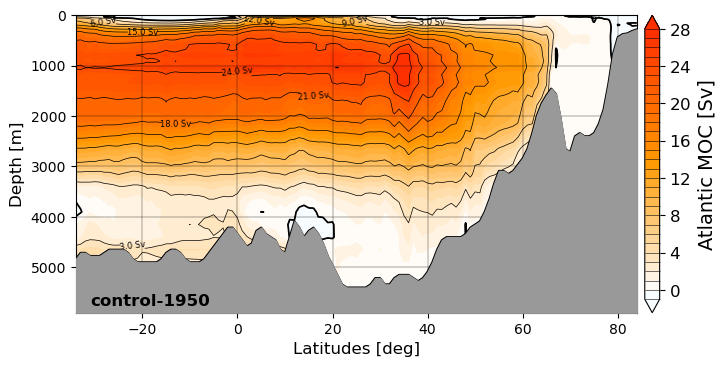

In [6]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
auxtime= zmoc_t['time.year'].values
slabel = f'y{auxtime[0]}-{auxtime[-1]}'
if spath is not None: spath  = os.path.join(spath,'{}_{}_{}_{}.png'.format(vname, which_model, which_run, slabel)) 
nrow, ncol= 1,1

#____________________________________________________________________________________________________
fig, ax, cbar=tpv.plot_zmoc([zmoc_t.mean(dim='time', keep_attrs=True)], which_moc=vname, cinfo=cinfo, figsize=[ncol*figfac[0], nrow*figfac[1]], 
                            n_rc=[nrow, ncol], pos_gap=[0.01, 0.04], pos_extend=[0.05, 0.05, 0.85, 0.90], 
                            do_save=spath, save_dpi=which_dpi, do_contour=True)

## > Compute: MOC time series @ latitude

In [7]:
zdefuc,zdeflc = [500,2000], [1500, 6000] # z-definition for upper/lower cell

#____________________________________________________________________________________________________
# compute time-series
if  vname == 'ipmoc' or vname == 'pmoc':
    zmoc_maxatlat = zmoc_t.where((zmoc_t['depth']>=zdeflc[0]) & (zmoc_t['depth']<=zdeflc[1])).min(dim='nz',skipna=True).rename({'zmoc':'zmoc_lcell'})
elif vname == 'amoc' or vname == 'aamoc':
    zmoc_ucell  = zmoc_t.where((zmoc_t['depth']>=zdefuc[0]) & (zmoc_t['depth']<=zdefuc[1])).max(dim='nz',skipna=True).rename({'zmoc':'zmoc_ucell'})
    zmoc_lcell  = zmoc_t.where((zmoc_t['depth']>=zdeflc[0]) & (zmoc_t['depth']<=zdeflc[1])).min(dim='nz',skipna=True).rename({'zmoc':'zmoc_lcell'})
    zmoc_maxatlat = xr.merge([zmoc_ucell, zmoc_lcell], compat='minimal' )
    del(zmoc_ucell, zmoc_lcell)

#_____________________________________________________________________________________________________
# save to netcdf
if (do_netcdf) and (save_path is not None) and (vname in ['amoc', 'aamoc', 'ipmoc', 'pmoc']):
    auxtime   = zmoc_t['time.year'].values
    sfname    = f'{vname}_at_lat_vs_t_{which_model}_{which_run}_y{auxtime[0]}-{auxtime[-1]}.nc'
    sfilepath = os.path.join(save_path, sfname)
    print(' --> save max. zmoc_t @ lat. to file:', sfname)
    zmoc_maxatlat.to_netcdf(path=sfilepath, mode='w')        

 --> save max. zmoc_t @ lat. to file: amoc_at_lat_vs_t_AWI-CM-1-1-HR_control-1950_y1951-2050.nc


## > Plot: MOC time-series @ latitude

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


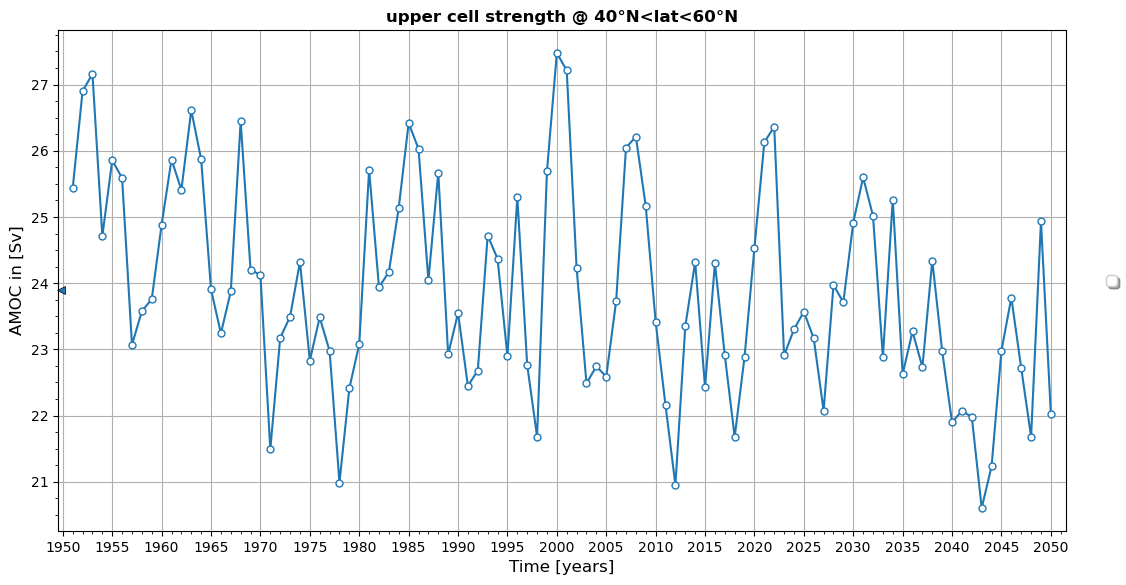

 > save figure: /albedo/home/pscholz/figures/test_MOC_f14cmip6/amoc_at_lat_vs_tAWI-CM-1-1-HR_control-1950_y1951-2050_nadw_40N<lat<60N.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


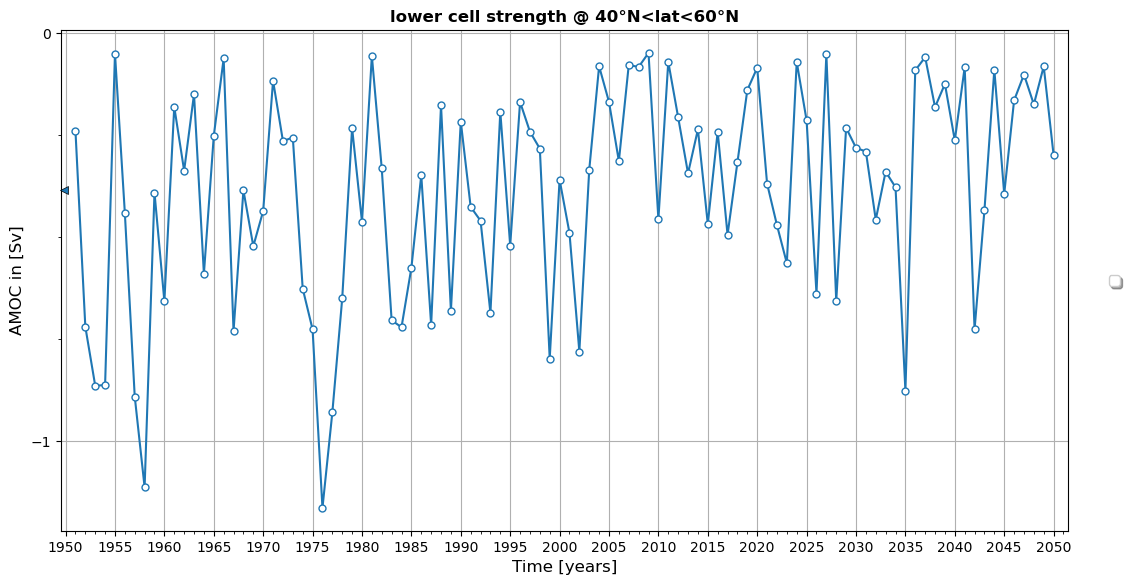

 > save figure: /albedo/home/pscholz/figures/test_MOC_f14cmip6/amoc_at_lat_vs_tAWI-CM-1-1-HR_control-1950_y1951-2050_aabw_40N<lat<60N.png


In [8]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
which_lat = ['max'] # 'max' # 'max', 26.0
spath  = save_path
auxtime   = zmoc_t['time.year'].values
slabel = f'y{auxtime[0]}-{auxtime[-1]}'
if spath is not None: spath  = os.path.join(spath,'{}_at_lat_vs_t{}_{}_{}.png'.format(vname, which_model, which_run, slabel)) 
fig,ax=tpv.plot_zmoc_tseries([zmoc_maxatlat], [None], which_lat=which_lat, which_moc=vname, 
                              do_save=spath, save_dpi=which_dpi, )  